In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


()

In [ ]:

# import zipfile

# zip_file_path = '/content/drive/MyDrive/CompVis/Data_Zip.zip'
# extract_folder_path = '/content/drive/MyDrive/CompVis/Data_Zip'

# # Dézipage du fichier
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder_path)

# print("Dézipage terminé.")




In [ ]:
import cv2
import os
import csv
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

<ipython-input-4-2f79ab5ec5f5>:15: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [ ]:
import os
import glob
import numpy as np

# Read training images path
def load_data(data_path):
    # Correction ici : utiliser le chemin complet lors de la recherche de dossiers
    folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
    imgs = []
    for folder in folders:
        # Correction ici : ajouter le chemin complet pour glob
        folder_path = os.path.join(data_path, folder)
        imgs.extend(glob.glob(folder_path + '/*.png'))  # Assurez-vous que l'extension est correcte
    return imgs

# Assurez-vous que les chemins sont corrects
vehicles_path = '/content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/vehicles'
non_vehicles_path = '/content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/non-vehicles'

proj_cars = load_data(vehicles_path)
proj_notcars = load_data(non_vehicles_path)

print(len(proj_cars))  # Devrait afficher le nombre de fichiers chargés pour les véhicules
print(len(proj_notcars))  # Devrait afficher le nombre de fichiers chargés pour les non-véhicules


8792
8968


The shape of images:  (64, 64)


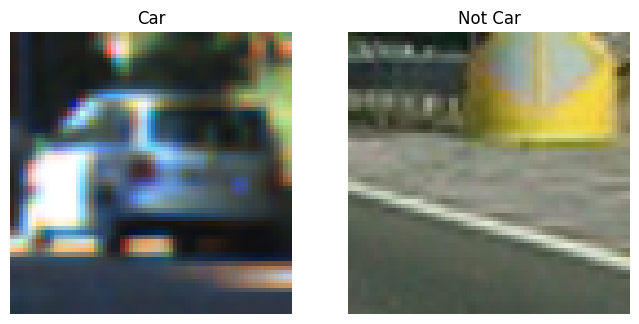

In [ ]:
# Generator a random index to look at an example of one each of vehicles and non-vehicles
ind = np.random.randint(0, 100)
car = cv2.imread(proj_cars[ind])
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)
notcar = cv2.imread(proj_notcars[ind])
notcar = cv2.cvtColor(notcar, cv2.COLOR_BGR2RGB)
print('The shape of images: ', (car.shape[1], car.shape[0]))

# Display the vehicle example and not-vehicle example
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(car)
axes[0].set_title('Car')
axes[0].set_axis_off()
axes[1].imshow(notcar)
axes[1].set_title('Not Car')
axes[1].set_axis_off()
plt.show()


In [ ]:


# Define a function to return Hog features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feat_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False,
                                  visualise=vis, feature_vector=feat_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys', transform_sqrt=False,
                       visualise=vis, feature_vector=feat_vec)
        return features

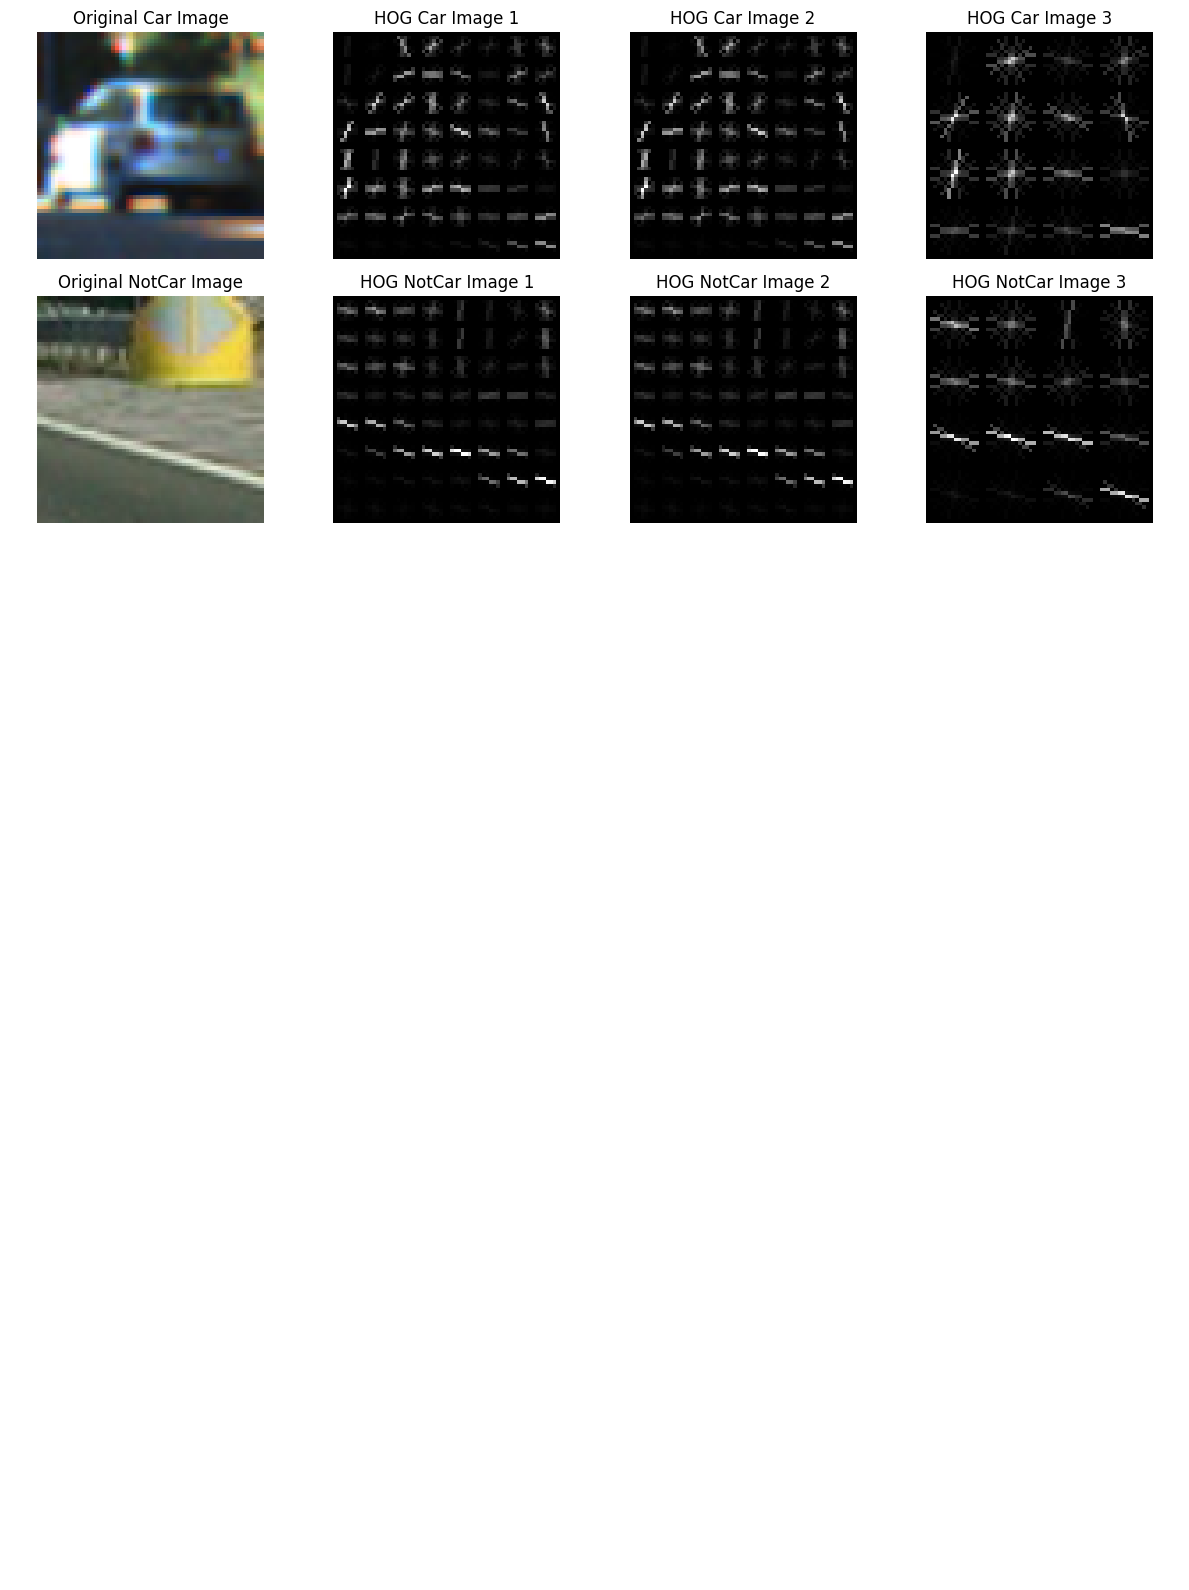

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Assuming 'car' and 'notcar' are valid images loaded into the environment

def get_hog_features(img, orient, pix_per_cell, cell_per_block, visualize=False, feature_vec=True):
    # skimage's hog function returns both features and a HOG image if visualize is True
    if visualize:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualize=visualize, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       visualize=visualize, feature_vector=feature_vec)
        return features

# Convert the car image and notcar image into grayscale
car_gray = cv2.cvtColor(car, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar, cv2.COLOR_RGB2GRAY)

# Visualize the hog features with different combination of parameters.
orient = [8, 16]
pix_per_cell = [8, 16]
cell_per_block = [2, 4]
car_hog_ls = []
notcar_hog_ls = []
for i in orient:
    for j in pix_per_cell:
        for k in cell_per_block:
            _, car_hog_image = get_hog_features(car_gray, orient=i, pix_per_cell=j, cell_per_block=k, visualize=True, feature_vec=False)
            car_hog_ls.append(car_hog_image)
            _, notcar_hog_image = get_hog_features(notcar_gray, orient=i, pix_per_cell=j, cell_per_block=k, visualize=True, feature_vec=False)
            notcar_hog_ls.append(notcar_hog_image)

# Plot the hog features visualization
fig, axes = plt.subplots(6, 4, figsize=(12,16))
for i in range(2):
    for j in range(4):
        if i == 0:
            if j == 0:
                axes[i][j].imshow(car, cmap='gray')
                axes[i][j].set_title('Original Car Image')
            else:
                axes[i][j].imshow(car_hog_ls[j-1], cmap='gray')
                axes[i][j].set_title(f'HOG Car Image {j}')
        else:
            if j == 0:
                axes[i][j].imshow(notcar, cmap='gray')
                axes[i][j].set_title('Original NotCar Image')
            else:
                axes[i][j].imshow(notcar_hog_ls[j-1], cmap='gray')
                axes[i][j].set_title(f'HOG NotCar Image {j}')

for ax in axes.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()


Error: Unable to read image '/content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/vehicles/vehicles/1963.png'. Skipping...
Error: Unable to read image '/content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/vehicles/vehicles/1963.png'. Skipping...
Error: Unable to read image '/content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/vehicles/vehicles/1963.png'. Skipping...
Error: Unable to read image '/content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/vehicles/vehicles/1963.png'. Skipping...
Error: Unable to read image '/content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/vehicles/vehicles/1963.png'. Skipping...
Error: Unable to read image '/content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/vehicles/vehicles/1963.png'. Skipping...


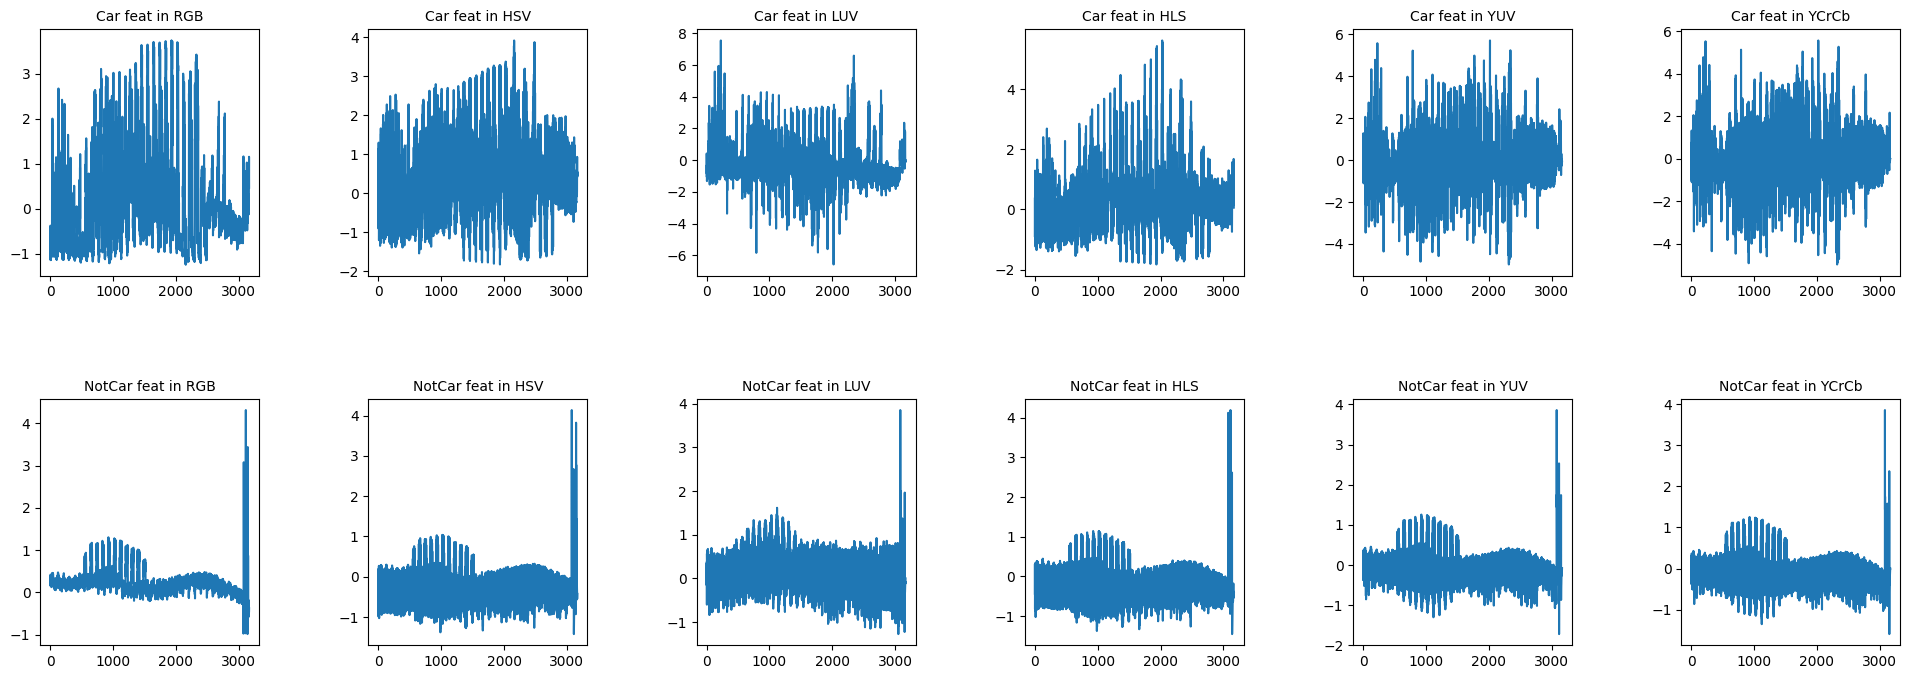

In [ ]:
# Define a function to get raw pixel values
def bin_spatial(img, size=(32,32)):
    features = cv2.resize(img, size).ravel()
    return features

# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0,256)):
    ch1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))
    return hist_features

# Combine the raw pixel values and color histogram features
def hist_features(imgs, cspace='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0,256)):
    features = []
    for file in imgs:
        img = cv2.imread(file)
        if img is None:
            print(f"Error: Unable to read image '{file}'. Skipping...")
            continue  # Skip to the next image if unable to read
        if cspace == 'RGB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif cspace == "YCrCb":
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((spatial_features, hist_features)))
    return features


# Explore the features of the car and notcar image in different color space
color_space = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
car_feat_in_cs = []
notcar_feat_in_cs = []
for cs in color_space:
    car_hist_feat = hist_features(proj_cars, cspace=cs)
    notcar_hist_feat = hist_features(proj_notcars, cspace=cs)

    # Normalize the features
    X = np.vstack((car_hist_feat, notcar_hist_feat)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    car_feat_in_cs.append(scaled_X[ind])
    notcar_feat_in_cs.append(scaled_X[ind+len(proj_cars)])

# Plot the car features and notcar features
fig, axes = plt.subplots(2,6,figsize=(24,8))
fig.subplots_adjust(wspace = 0.5, hspace =0.5)
for i, (car_feat, notcar_feat) in enumerate(zip(car_feat_in_cs, notcar_feat_in_cs)):
    axes[0][i].plot(car_feat)
    axes[0][i].set_title('Car feat in ' + color_space[i], fontsize=10)
    axes[1][i].plot(notcar_feat)
    axes[1][i].set_title('NotCar feat in ' + color_space[i], fontsize=10)
plt.show()

In [ ]:
import time
import cv2
import numpy as np

def extract_features(img, spatial_feat=True, hist_feat=True, hog_feat=True, hog_channel='ALL',
                     orient=14, pix_per_cell=8, cell_per_block=2):
    if img is None:
        return np.array([])  # Return an empty array if the image is None
    img_features = []
    feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    if spatial_feat:
        spatial_features = bin_spatial(feature_image)
        img_features.append(spatial_features)

    if hist_feat:
        hist_features = color_hist(feature_image)
        img_features.append(hist_features)

    if hog_feat:
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                features = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block)
                if features is not None and features.size > 0:
                    hog_features.append(features)
            if hog_features:  # Only concatenate if hog_features is not empty
                hog_features = np.concatenate(hog_features).ravel()
            else:
                hog_features = np.array([])
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block)
            if hog_features is None or hog_features.size == 0:
                hog_features = np.array([])
            else:
                hog_features = hog_features.ravel()
        img_features.append(hog_features)

    return np.concatenate(img_features) if img_features else np.array([])

# Ensure get_hog_features() is correctly returning a 1D array suitable for concatenation.
# def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
#     # This is just a placeholder. Your actual implementation may vary.
#     # Make sure this function returns a numpy array with at least one dimension.
#     return np.random.rand(100)  # Example: returns a 1D array of random numbers



# def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
#     # Utilisation de skimage pour obtenir les caractéristiques HOG
#     from skimage.feature import hog
#     features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
#                    cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys', visualize=False,
#                    feature_vector=feature_vec)
#     return features



from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
               cells_per_block=(cell_per_block, cell_per_block), visualize=False,
               feature_vector=feature_vec)




t = time.time()
car_features = []
notcar_features = []

for img in proj_cars:
    image = cv2.imread(img)
    if image is not None:
        features = extract_features(image)
        if features.size > 0:
            car_features.append(features)
    else:
        print(f"Failed to load image: {img}")

for img in proj_notcars:
    image = cv2.imread(img)
    if image is not None:
        features = extract_features(image)
        if features.size > 0:
            notcar_features.append(features)
    else:
        print(f"Failed to load image: {img}")

t2 = time.time()
print(f"Time to extract features: {t2 - t} seconds")


Failed to load image: /content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/vehicles/vehicles/1963.png
Time to extract features: 333.79805064201355 seconds


In [ ]:


# Combine the car_features and notcar_features
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Add labels to the car_features and notcar_features
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#rand_state = np.random.randint(0, 100)
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalize features
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [ ]:


# Use a linear SVC
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
acc = svc.score(X_test, y_test)
print('Test Accuracy of SVC = ', round(acc, 4))

# Check the prediction time for 10 samples
t = time.time()
n_predict = 10
print('My SVC precicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'lables: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict, 'labels with SVC')

8.85 Seconds to train SVC...
Test Accuracy of SVC =  0.9952
My SVC precicts:  [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
For these 10 lables:  [1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
0.00315 Seconds to predict 10 labels with SVC


In [ ]:
import numpy as np
import cv2

# Define a function to draw boxes on an image
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=3):
    out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for bbox in bboxes:
        cv2.rectangle(out_img, bbox[0], bbox[1], color, thick)
    return out_img

# Define a function to slide a given window on an image
def slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 656], xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = int(xy_window[1] * (1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_buffer = int(xy_window[0] * xy_overlap[0])
    ny_buffer = int(xy_window[1] * xy_overlap[1])
    nx_windows = int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = int((yspan - ny_buffer) / ny_pix_per_step)

    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

# Define a function that inputs an image and the list of windows to be searched, returns windows for positive detections
def search_windows(img, windows, clf, scaler):
    on_windows = []
    for window in windows:
        # Extract the window from original image
        subimg = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Extract features for that window using extract_features()
        features = extract_features(subimg)
        # Scale extracted features to be fed to classifier
        scaled_features = scaler.transform(np.array([features]))  # Ensure that features is a 2D array for scaling
        # Predict using the classifier
        prediction = clf.predict(scaled_features)
        # Return windows for positive detections
        if prediction == 1:
            on_windows.append(window)
    return on_windows


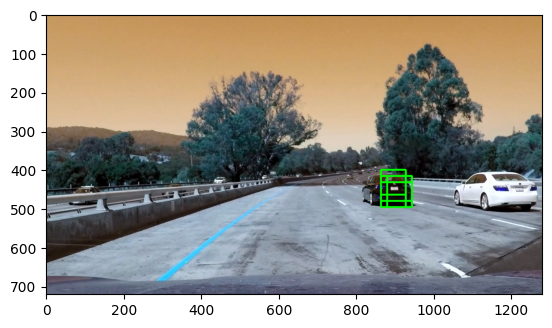

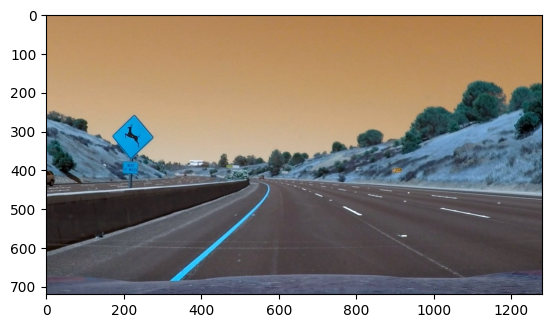

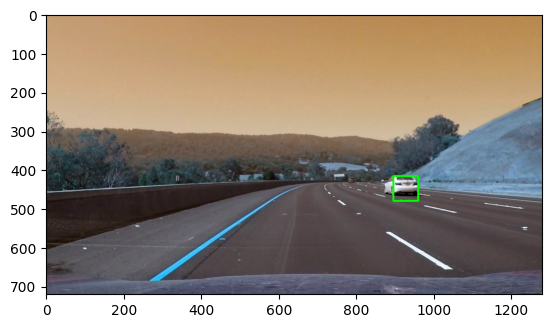

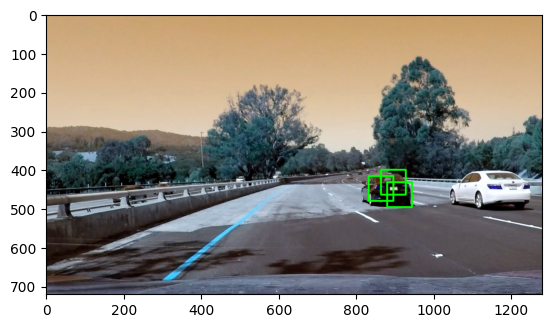

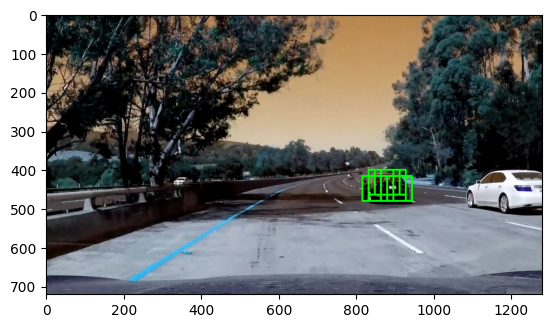

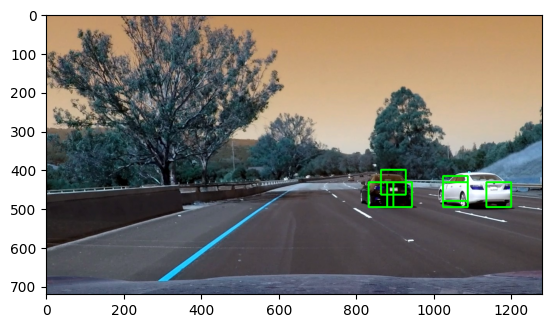

In [ ]:
import cv2

# Ensure svc and X_scaler are defined as shown above
img_files = glob.glob('/content/drive/MyDrive/CompVis/Data_Zip/Data_Zip/SW_Test/test_images/*.jpg')
for file in img_files:
    img = cv2.imread(file)
    if img is not None:
        windows = slide_window(img)
        hot_windows = search_windows(img, windows, svc, X_scaler)  # Ensure svc and X_scaler are not None
        window_img = draw_boxes(img, hot_windows)
        plt.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print("Error: Failed to load image. Check the file path:", file)


In [ ]:
import numpy as np
import cv2

orient = 14
pix_per_cell = 8
cell_per_block = 2

ystart = 400
ystop = 656
scale = 1.1

def find_cars(img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block):
    draw_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)

    bboxes = []
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(imshape[1] / scale), int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block**2

    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)
            test_features = np.hstack((spatial_features, hist_features, hog_features))
            scaled_features = scaler.transform(test_features.reshape(1, -1))
            test_prediction = svc.predict(scaled_features)

            if test_prediction == 1:
                xbox_left = int(xleft * scale)
                ytop_draw = int(ytop * scale)
                win_draw = int(window * scale)
                box = ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart))
                cv2.rectangle(draw_img, box[0], box[1], (0, 0, 255), 6)
                bboxes.append(box)
    return bboxes, draw_img


In [ ]:
# Display some example images using the find_cars function
for file in img_files:
    img = cv2.imread(file)
    _, out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    plt.imshow(out_img)
    plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))
        label = self.read_label(label_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    def read_label(self, file_path):
        with open(file_path, 'r') as file:
            label = int(file.readline().strip().split()[0])
        return label


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Cette opération réduit les dimensions par 2
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Calculez la taille correcte ici, 56x56 est un placeholder, remplacez-le par vos valeurs
        self.fc1 = nn.Linear(32 * 56 * 56, 512)  # Adaptez 56x56 selon les dimensions de sortie de vos couches
        self.fc2 = nn.Linear(512, 5)  # Si 5 classes

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      print(x.shape)  # Ajoutez cette ligne pour voir la forme de x avant le flattening
      x = x.view(-1, 32 * 56 * 56)  # Assurez-vous que cette valeur est correcte
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x





In [ ]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(
    img_dir='/content/drive/MyDrive/CompVis/vehicule/VehiclesDetectionDataset/train/images',
    label_dir='/content/drive/MyDrive/CompVis/vehicule/VehiclesDetectionDataset/train/labels',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [ ]:
import torch

model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Pour calculer l'accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

for epoch in range(2):
    running_loss = 0.0
    total_accuracy = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_accuracy += calculate_accuracy(outputs, labels)

    average_loss = running_loss / len(train_loader)
    average_accuracy = total_accuracy / len(train_loader)
    print(f'Epoch {epoch+1}: Loss = {average_loss:.4f}, Accuracy = {average_accuracy:.4f}')

print('Finished Training')


torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([14, 32, 56, 56])
Epoch 1: Loss = 4.7049, Accuracy = 0.3367
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
t

In [ ]:


from sklearn.metrics import precision_score, recall_score, f1_score

# Supposons que vous avez accumulé toutes les vraies étiquettes et toutes les prédictions dans ces listes
true_labels = []
predicted_labels = []

for images, labels in train_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    true_labels.extend(labels.tolist())
    predicted_labels.extend(predicted.tolist())

precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([32, 32, 56, 56])
torch.Size([14, 32, 56, 56])
Precision: 0.8819, Recall: 0.7057, F1 Score: 0.7654


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os


In [ ]:


def sliding_window(image, step_size, window_size):
    """Slide a window across the image"""
    for y in range(0, image.size[1] - window_size[1], step_size):
        for x in range(0, image.size[0] - window_size[0], step_size):
            yield (x, y, image.crop((x, y, x + window_size[0], y + window_size[1])))


In [ ]:
def evaluate_image(model, image_path, window_size=(64, 64), step_size=32):
    image = Image.open(image_path).convert('RGB')
    image_transform = transforms.Compose([
        transforms.Resize(window_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    detections = []
    for x, y, window in sliding_window(image, step_size, window_size):
        input_tensor = image_transform(window).unsqueeze(0)
        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()
            model = model.cuda()

        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            score = F.softmax(output, dim=1)[0][predicted.item()].item()

        if predicted.item() == 1 and score > 0.5:  # Assuming class '1' is your object class
            detections.append((x, y, score))

    return image, detections


In [ ]:


def draw_detections(image, detections):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for x, y, score in detections:
        rect = patches.Rectangle((x, y), window_size[0], window_size[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y, f"{score:.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()



In [ ]:


model = SimpleCNN()  # Assurez-vous que le modèle est correctement chargé ou formé
model.eval()  # Mettez le modèle en mode évaluation

image_path = '/content/drive/MyDrive/CompVis/vehicule/VehiclesDetectionDataset/test/images/00e481ea1a520175_jpg.rf.6e6a8b3b45c9a11d106958f88ff714ea.jpg'
image, detections = evaluate_image(model, image_path)
draw_detections(image, detections)
